# Explaining `disp` for future ref.

## Notebook using data from `cta-lstchain-extra`

In case you have not cloned `cta-lstchain-extra` repository:

git clone https://github.com/cta-observatory/cta-lstchain-extra

### Some imports...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from copy import deepcopy

from ctapipe.calib import CameraCalibrator
from ctapipe.image import tailcuts_clean
from ctapipe.io import EventSource
from ctapipe.image import hillas_parameters
from ctapipe.visualization import CameraDisplay
from lstchain.reco.utils import *
from lstchain.visualization.camera import *
from lstchain.io import DispContainer, get_standard_config
from lstchain.reco.disp import disp_vector, disp_parameters_event
from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource
from ctapipe.instrument import SubarrayDescription, subarray

In [2]:
infile = get_dataset_path("gamma_test_large.simtel.gz")

source = EventSource(infile, max_events=10)

In [3]:
infile = get_dataset_path("gamma_test_large.simtel.gz")


cal = CameraCalibrator(source.subarray)

cleaning_method = tailcuts_clean
cleaning_parameters = {
    "boundary_thresh": 4,
    "picture_thresh": 7,
    "min_number_picture_neighbors": 3,
}



In [4]:
events = [deepcopy(event) for event in source]

### We select a bright event

In [5]:
intensity = 0
for event in events:
    cal(event)
    for tid in event.r0.tel.keys():
        if event.dl1.tel[tid].image.sum() > intensity:
            intensity = event.dl1.tel[tid].image.sum()
            bright_event = deepcopy(event)
            tel_id = tid
event = bright_event

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Image cleaning, hilas parameters and plotting of the shower

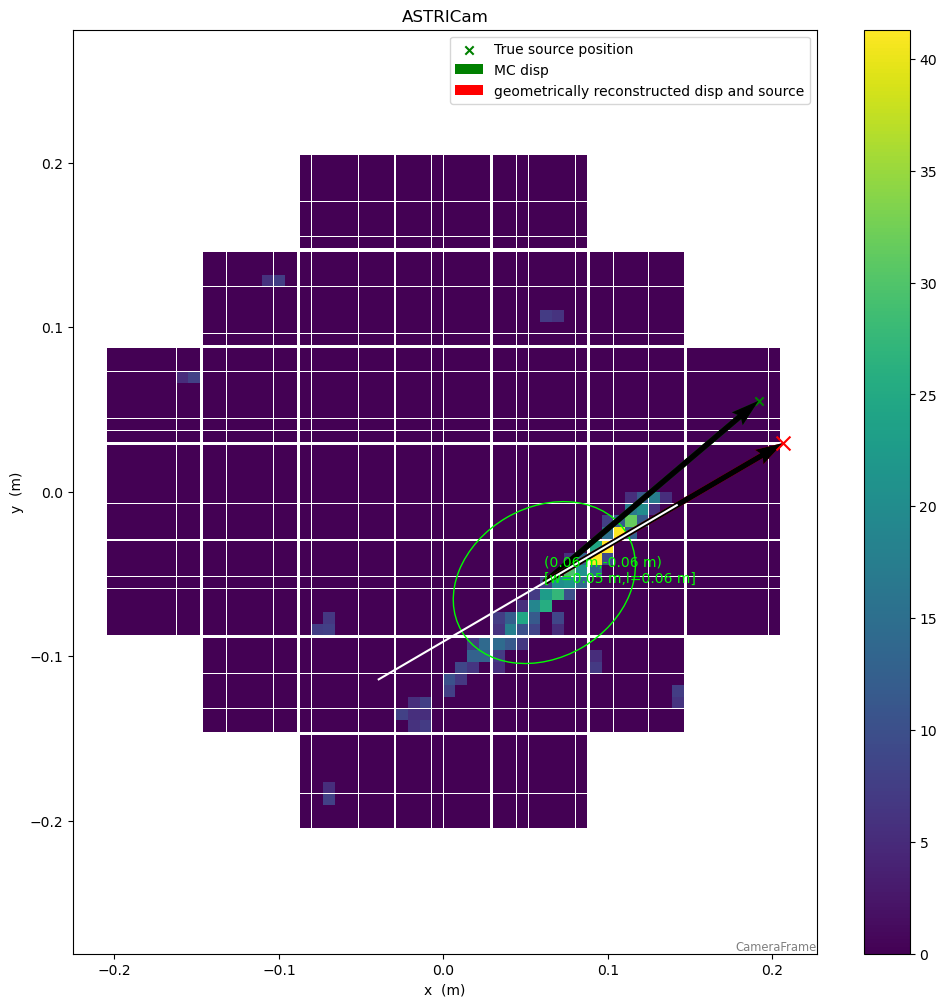

In [6]:
event = bright_event
tel_id = 31

tel = source.subarray.tel[tel_id]
geom = tel.camera.geometry
image = event.dl1.tel[tel_id].image

pixel_signals = tailcuts_clean(geom, image)
cleaned = deepcopy(image)
cleaned[~pixel_signals] = 0
hillas = hillas_parameters(geom, cleaned)


plt.figure(figsize=(12,12))
display = CameraDisplay(geom, cleaned, cmap=plt.get_cmap('viridis'))
display.overlay_moments(hillas, color='lime')
display.add_colorbar()

pointing_alt = event.pointing.array_altitude
pointing_az = event.pointing.array_azimuth
src_pos = sky_to_camera(event.simulation.shower.alt,
                        event.simulation.shower.az, 
                        tel.optics.equivalent_focal_length, 
                        event.pointing.tel[tel_id].altitude,
                        event.pointing.tel[tel_id].azimuth,
                       )


disp = disp_parameters_event(hillas, src_pos.x, src_pos.y)

overlay_source(display, src_pos.x, src_pos.y, color='green', label='True source position')

overlay_disp_vector(display, disp, hillas, color='green', label='MC disp')

# if disp was reconstructed with the norm and side
disp_r = DispContainer()
disp_r.angle = hillas.psi
disp_r.sign = disp.sign
disp_r.norm = disp.norm
disp_r.dx, disp_r.dy = disp_vector(disp_r.norm.value, disp_r.angle.value, disp_r.sign) * u.m
overlay_disp_vector(display, disp_r, hillas, color='red', label='geometrically reconstructed disp and source')
overlay_source(display, hillas.x+disp_r.dx, hillas.y+disp_r.dy, color='red', s=100)

overlay_hillas_major_axis(display, hillas, color='white')

plt.legend()

## Disp reconstruction

In [7]:
import pandas as pd
from lstchain.reco.dl1_to_dl2 import train_disp_vector

In [8]:
gammas = pd.read_hdf('../../cta-lstchain-extra/reco/sample_data/dl2/ctapipe_diffuse_dl2_tiny.h5')

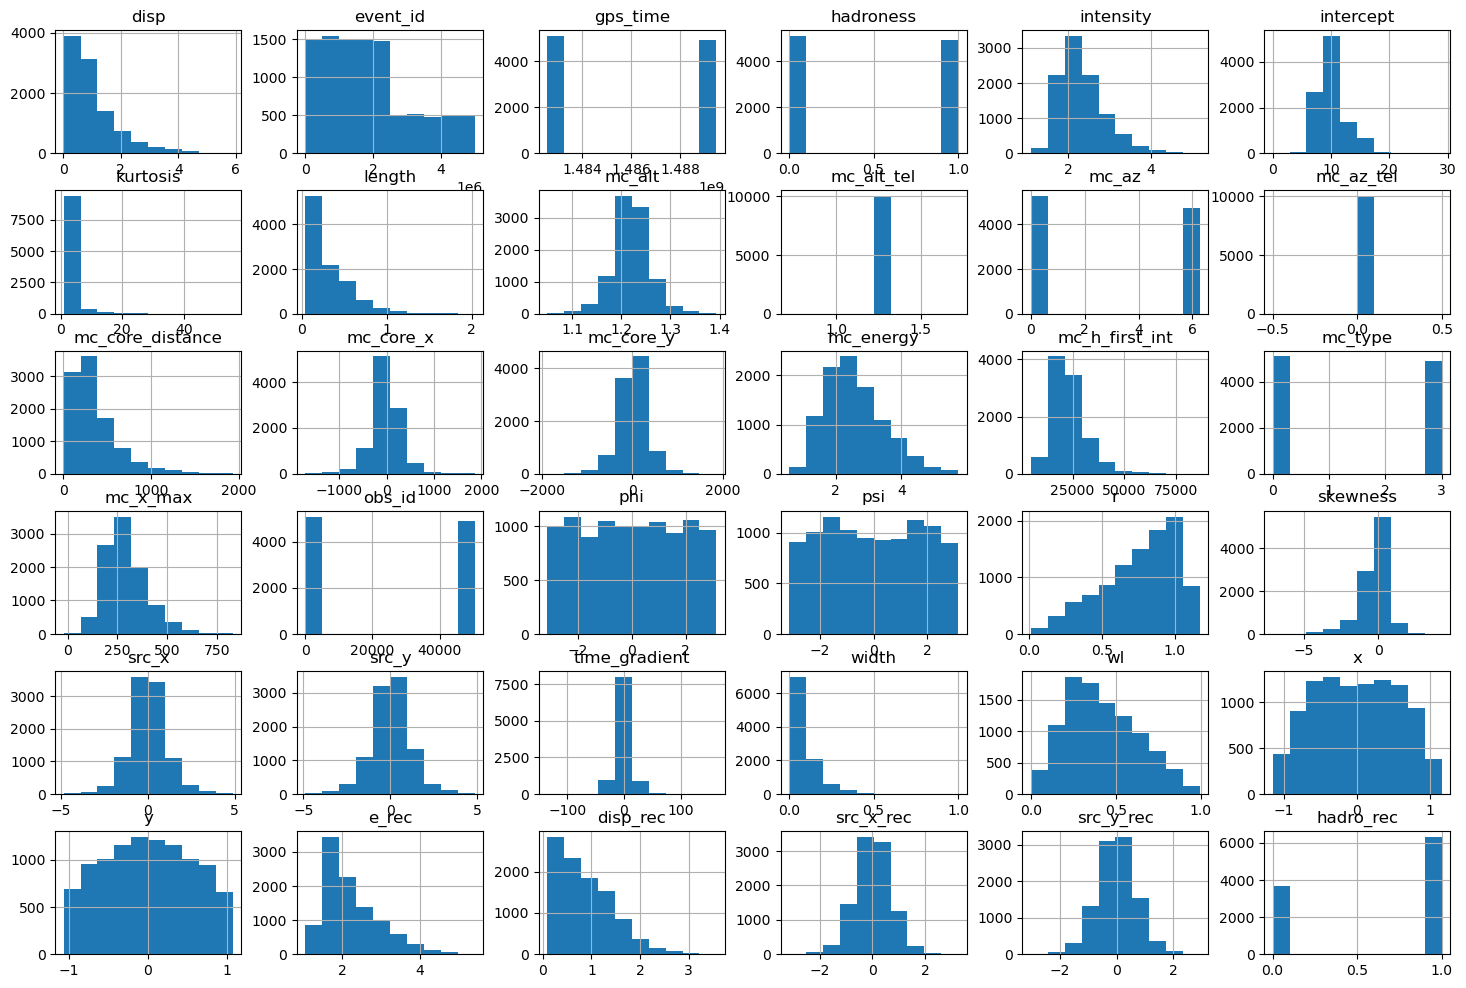

In [9]:
gammas.hist(figsize=(18,12));

In [10]:
gammas['disp_norm'] = gammas.disp
gammas['disp_dx'] = gammas.src_x - gammas.x
gammas['disp_dy'] = gammas.src_y - gammas.y
gammas['disp_sign'] = np.sign(gammas['disp_dx'])
gammas['disp_angle'] = gammas.psi

In [12]:
training_features = ['intensity', 'width', 'length', 'x', 'y', 'psi', 'phi', 'wl', 
                     'skewness', 'kurtosis', 'r', 'intercept', 'time_gradient']

predict_features = ['disp_dx', 'disp_dy']

custom_config = get_standard_config()
custom_config['disp_regression_features'] = training_features
custom_config['random_forest_regressor_args'] = {'n_jobs': 4, 
                                                 # 'min_samples_leaf': 5,
                                                 # 'max_depth': 50,
                                                 # 'n_estimators': 450
                                                }

rf_disp_vec = train_disp_vector(gammas, 
                                custom_config=custom_config,
                                predict_features=predict_features
                               )

Given features:  ['intensity', 'width', 'length', 'x', 'y', 'psi', 'phi', 'wl', 'skewness', 'kurtosis', 'r', 'intercept', 'time_gradient']
Number of events for training:  10000
Training model <class 'sklearn.ensemble._forest.RandomForestRegressor'> for disp vector regression
Model <class 'sklearn.ensemble._forest.RandomForestRegressor'> trained!


In [13]:
disp_vec_reco = rf_disp_vec.predict(gammas[training_features])

disp_dx_reco = disp_vec_reco[:,0]
disp_dy_reco = disp_vec_reco[:,1]

reco_src_x = gammas.x + disp_dx_reco
reco_src_y = gammas.y + disp_dy_reco

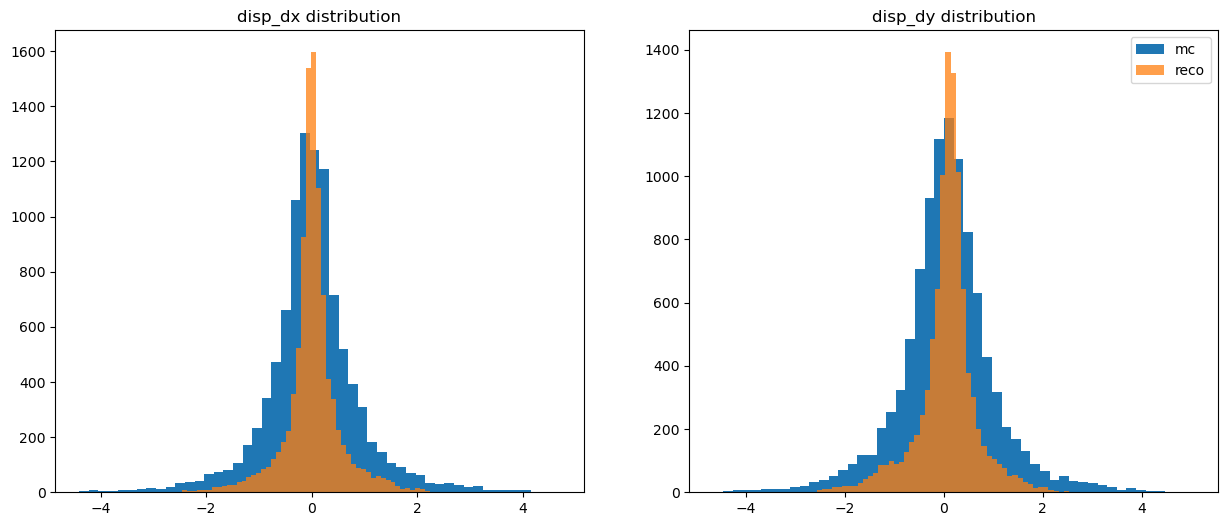

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

axes[0].hist(gammas.disp_dx, bins=50, label='mc');
axes[0].hist(disp_dx_reco, bins=50, alpha=0.75, label='reco');
axes[0].set_title('disp_dx distribution')
axes[1].hist(gammas.disp_dy, bins=50, label='mc');
axes[1].hist(disp_dy_reco, bins=50, alpha=0.75, label='reco');
axes[1].set_title('disp_dy distribution')
plt.legend();

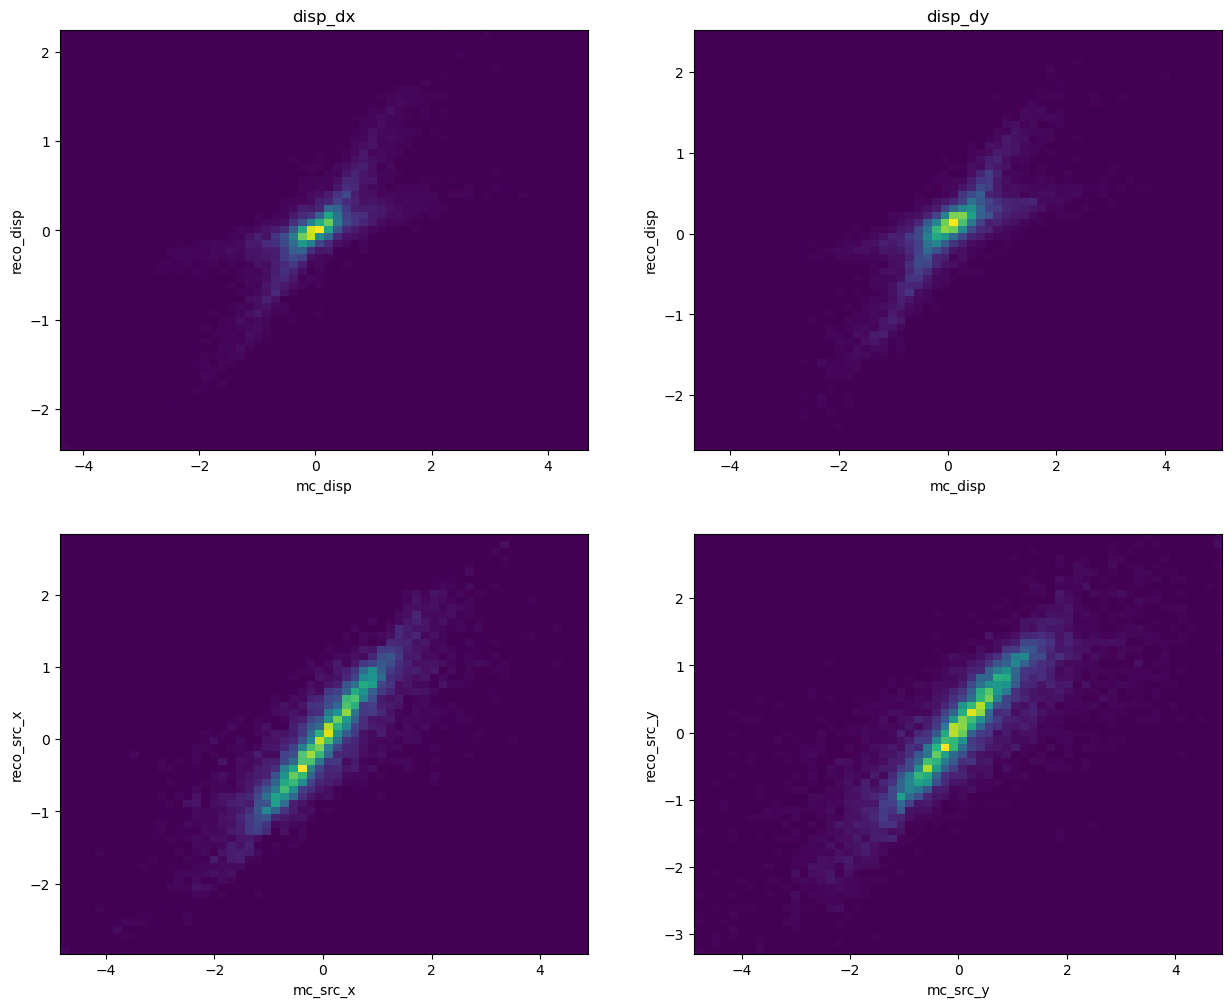

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15,12))

axes[0,0].hist2d(gammas.disp_dx, disp_dx_reco, bins=60);
axes[0,0].set_xlabel('mc_disp')
axes[0,0].set_ylabel('reco_disp')
axes[0,0].set_title('disp_dx')

axes[0,1].hist2d(gammas.disp_dy, disp_dy_reco, bins=60);
axes[0,1].set_xlabel('mc_disp')
axes[0,1].set_ylabel('reco_disp')
axes[0,1].set_title('disp_dy');


axes[1,0].hist2d(gammas.src_x, reco_src_x, bins=60);
axes[1,0].set_xlabel('mc_src_x')
axes[1,0].set_ylabel('reco_src_x')

axes[1,1].hist2d(gammas.src_y, reco_src_y, bins=60);
axes[1,1].set_xlabel('mc_src_y')
axes[1,1].set_ylabel('reco_src_y');